In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, MWETokenizer
from nltk.util import ngrams
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tag import pos_tag
from nltk.stem.lancaster import LancasterStemmer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from gensim import corpora, models, matutils
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

In [2]:
df_train = pd.read_csv("/Users/che-yuliu/Desktop/Metis_DSC_Bootcamp/NLP/Project/archive (1)/drugsComTrain_raw.csv")
df_test = pd.read_csv("/Users/che-yuliu/Desktop/Metis_DSC_Bootcamp/NLP/Project/archive (1)/drugsComTest_raw.csv")

__Goal of project: Run a sentiment analysis to find out what patients are most concerned about in their medication and recommend what to include in a description. <br> MVP Goal: Run EDA, vectorize the reviews, run a sentiment analysis on the reviews and see how they relate to the useful count.__

__Conduct EDA on train data__

In [3]:
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


In [4]:
df_train.columns = df_train.columns.str.lower()

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueid     161297 non-null  int64 
 1   drugname     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulcount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


__Condition column has 999 NaN values, will drop these rows as condition is very important to this project__ 

[Text(0.5, 1.0, 'Ratings Distribution')]

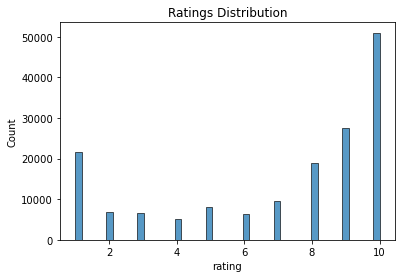

In [6]:
# Check distribution of rating and usefulcount 
sns.histplot(df_train["rating"]).set(title = "Ratings Distribution")

[Text(0.5, 1.0, 'Useful Count Distribution')]

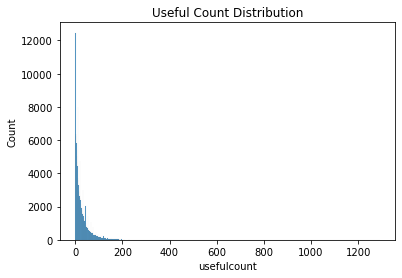

In [7]:
sns.histplot(df_train["usefulcount"]).set(title = "Useful Count Distribution")

In [8]:
df_train.loc[df_train["usefulcount"] == 0]

,uniqueid,drugname,condition,review,rating,date,usefulcount
16,48188,Trimethoprim,Urinary Tract Infection,"""This drug worked very well for me and cleared...",9,22-Sep-17,0
38,60678,MoviPrep,Bowel Preparation,"""I have taken this at least 5-6 times for the ...",2,29-Jun-17,0
45,111409,Ledipasvir / sofosbuvir,Hepatitis C,"""At initial testing my VL was over 6 million. ...",10,22-Sep-15,0
97,60280,NuvaRing,Birth Control,"""I am torn by the Nuvaring. The convenience is...",5,31-Oct-11,0
101,229524,Lurasidone,Schizophrenia,"""I&#039;ve been on Latuda for a little under 2...",8,26-Sep-15,0
...,...,...,...,...,...,...,...
161252,230002,Myobloc,Cervical Dystonia,"""I was given this for spasms in upper spine an...",1,22-Nov-17,0
161257,142183,Levonorgestrel,Birth Control,"""There are some bad reviews about Kyleena - so...",10,6-Dec-17,0
161273,109111,Nexplanon,Birth Control,"""I have had the Nexplanon since Dec. 27, 2016 ...",6,6-Apr-17,0
161276,176146,Lorazepam,Anxiety,"""About 4 years ago I started having early-morn...",8,21-Nov-17,0


__It seems like the most recent reviews have 0 people who have found the review useful__

In [9]:
# Converting date into a datetime object, I want to see if the it is the nature of a recent date causing 0 reviews. 
df_train["date"] = pd.to_datetime(df_train["date"])

In [10]:
df_train_date_sorted = df_train.sort_values(by = "date", ascending = False)
df_train_date_sorted

,uniqueid,drugname,condition,review,rating,date,usefulcount
5833,65582,Propranolol,mance Anxiety,"""I suffer from glossophobia or the fear of pub...",10,2017-12-12,0
8211,101565,Vaniqa,Hirsutism,"""I&#039;m thrilled with this product. After us...",10,2017-12-12,0
140284,160088,Rivaroxaban,Atrial Fibrillation,"""I made a comment here a couple of years ago w...",1,2017-12-12,0
1421,162659,Terconazole,Vaginal Yeast Infection,"""This is the meanest diabolical cream. Not sur...",1,2017-12-12,0
110317,21945,Infliximab,Rheumatoid Arthritis,"""I was diagnosed with Inflammatory Arthritis (...",10,2017-12-12,0
...,...,...,...,...,...,...,...
51387,100894,Orlistat,Obesity,"""Xenical really helped me, but some of the bow...",7,2008-02-24,50
137363,136265,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,"""I when to a medical clinic with flu like symp...",1,2008-02-24,0
67737,190771,Oxybutynin,Not Listed / Othe,"""Improved my problem dramatically. I never exp...",7,2008-02-24,22
52404,20345,Macrobid,Bladder Infection,"""Excellent for prevention of bladder infection...",8,2008-02-24,52


In [11]:
df_train_date_sorted.head(100)

,uniqueid,drugname,condition,review,rating,date,usefulcount
5833,65582,Propranolol,mance Anxiety,"""I suffer from glossophobia or the fear of pub...",10,2017-12-12,0
8211,101565,Vaniqa,Hirsutism,"""I&#039;m thrilled with this product. After us...",10,2017-12-12,0
140284,160088,Rivaroxaban,Atrial Fibrillation,"""I made a comment here a couple of years ago w...",1,2017-12-12,0
1421,162659,Terconazole,Vaginal Yeast Infection,"""This is the meanest diabolical cream. Not sur...",1,2017-12-12,0
110317,21945,Infliximab,Rheumatoid Arthritis,"""I was diagnosed with Inflammatory Arthritis (...",10,2017-12-12,0
...,...,...,...,...,...,...,...
103804,150305,Sulfamethoxazole / trimethoprim,Urinary Tract Infection,"""I had a UTI and was placed on this drug. Firs...",2,2017-12-10,0
156625,214569,Escitalopram,Irritable Bowel Syndrome,"""I took escitalopram 10mg for 6 month for a li...",1,2017-12-10,0
31663,52775,Elmiron,Interstitial Cystitis,"""This medicine has saved me from living in pai...",10,2017-12-10,0
68982,217189,Clarithromycin,Tonsillitis/Pharyngitis,"""I have really bad swollen tonsils for some re...",3,2017-12-10,0


In [12]:
df_train_date_sorted.loc[df_train_date_sorted["date"].dt.year == 2017]

,uniqueid,drugname,condition,review,rating,date,usefulcount
5833,65582,Propranolol,mance Anxiety,"""I suffer from glossophobia or the fear of pub...",10,2017-12-12,0
8211,101565,Vaniqa,Hirsutism,"""I&#039;m thrilled with this product. After us...",10,2017-12-12,0
140284,160088,Rivaroxaban,Atrial Fibrillation,"""I made a comment here a couple of years ago w...",1,2017-12-12,0
1421,162659,Terconazole,Vaginal Yeast Infection,"""This is the meanest diabolical cream. Not sur...",1,2017-12-12,0
110317,21945,Infliximab,Rheumatoid Arthritis,"""I was diagnosed with Inflammatory Arthritis (...",10,2017-12-12,0
...,...,...,...,...,...,...,...
91015,6559,Wellbutrin XL,Major Depressive Disorde,"""Increasing dose from 150mg to 300mg daily sto...",3,2017-01-01,7
79435,154881,Metronidazole,Clostridial Infection,"""Absolutely hate this medication. I&#039;ve be...",1,2017-01-01,7
43647,26959,Ultram,Pain,"""Dose not work only made me anxious and angry ...",1,2017-01-01,32
130840,54894,Bupropion / naltrexone,Obesity,"""I&#039;m on the 4th week of taking Contrave, ...",10,2017-01-01,98


__It could be that towards the end of the 2017 not enough time was given for other users to take a look at the reviews so these will potentially be dropped from the overall dataset.__

In [13]:
# Creating a column using rating as a metric of determining if it was a positive or negative review
senttype = []
for rating in df_train["rating"]:
    if rating > 5: 
        rating = "pos"
        senttype.append(rating)
    else: 
        rating = "neg"
        senttype.append(rating)

In [14]:
df_train["senttype"] = senttype
df_train.rename(columns={"senttype" : "senttype_rating"})

,uniqueid,drugname,condition,review,rating,date,usefulcount,senttype_rating
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,pos
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,pos
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,neg
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,pos
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,pos
...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,2015-05-31,125,pos
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,2011-11-01,34,neg
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,2014-03-15,35,neg
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,2015-09-19,79,pos


__Conducting Pre-processing (vocabulary) of the reviews__ 

In [15]:
# Removing the quotations from the review column 
df_train["review"] = df_train["review"].apply(lambda x : x.replace('"', ''))

In [16]:
# Setting the "review" column as a variable to easily access it
train_corpus = df_train["review"].str.split()

In [17]:
train_corpus

0         [It, has, no, side, effect,, I, take, it, in, ...
1         [My, son, is, halfway, through, his, fourth, w...
2         [I, used, to, take, another, oral, contracepti...
3         [This, is, my, first, time, using, any, form, ...
4         [Suboxone, has, completely, turned, my, life, ...
                                ...                        
161292    [I, wrote, my, first, report, in, Mid-October,...
161293    [I, was, given, this, in, IV, before, surgey.,...
161294    [Limited, improvement, after, 4, months,, deve...
161295    [I&#039;ve, been, on, thyroid, medication, 49,...
161296    [I&#039;ve, had, chronic, constipation, all, m...
Name: review, Length: 161297, dtype: object

In [18]:
# Removing all stop words
# will not want to remove adjectives as I believe they add to the "usefulnes" of a review
# creating a function that will take in a corpus and tokenize all the words in the 

__Begin vectorizing the reviews__

In [19]:
# Doing CountVectorizer first. 
reviews = df_train["review"]
cv = CountVectorizer(stop_words = "english")
X = cv.fit_transform(reviews)
cv_matrix = pd.DataFrame(X.toarray(), columns = cv.vocabulary_)

In [ ]:
lsa = TruncatedSVD()
lsa.fit(cv_matrix)

__Trying out spaCy as it seems much more efficient and simpler to use for VADER__

In [30]:
nlp = spacy.load("en_core_web_sm")

In [89]:
all_stopwords = nlp.Defaults.stop_words


In [42]:
df_train["spacy_text"] = list(nlp.pipe(df_train["review"]))
df_train["spacy_text"].head(10)

0    (It, has, no, side, effect, ,, I, take, it, in...
1    (My, son, is, halfway, through, his, fourth, w...
2    (I, used, to, take, another, oral, contracepti...
3    (This, is, my, first, time, using, any, form, ...
4    (Suboxone, has, completely, turned, my, life, ...
5    (2nd, day, on, 5, mg, started, to, work, with,...
6    (He, pulled, out, ,, but, he, cummed, a, bit, ...
7    (Abilify, changed, my, life, ., There, is, hop...
8    ( , I, Ve, had,  , nothing, but, problems, wit...
9    (I, had, been, on, the, pill, for, many, years...
Name: spacy_text, dtype: object

In [49]:
print("Number of non-unique words:", sum([len(d) for d in df_train["spacy_text"]]))
print("Number of documents:", len(df_train["spacy_text"]))

Number of non-unique words: 15583211
Number of documents: 161297


In [128]:
# Using a function to remove stop words from the corpus
# code was obtained from https://stackoverflow.com/questions/66658998/how-to-remove-stop-words-and-get-lemmas-in-a-pandas-data-frame-using-spacy
def remove_stops(doc) -> list:
    # Filter out stop words by using the `token.is_stop` attribute
    return [token.text for token in doc if not token.is_stop]

In [129]:
df_train['removed_stops'] = list(map(remove_stops, df_train["spacy_text"]))

In [140]:
# Getting the adjectives for each review
# Code obtained from Metis fancynlp exercise3 
adj_list = []
for doc in df_train.spacy_text:
    for token in doc:
        if token.pos_ == 'ADJ':
            adj_list.append(token.text.lower())

In [141]:
# Adjective list was obtained across the entire corpus
adj_list
# Next step is seeing if I can pull the adjectives for each document 

['side',
 'fourth',
 'concerned',
 'last',
 'highest',
 'cranky',
 'unusual',
 'few',
 'last',
 'free',
 'agreeable',
 'emotional',
 'good',
 'cranky',
 'better',
 'many',
 'different',
 'effective',
 'oral',
 'happy-',
 'light',
 'other',
 'available',
 'similar',
 'other',
 'first',
 'second',
 'same',
 'third',
 'third',
 'third',
 'daily',
 'brown',
 'positive',
 'other',
 'free',
 'tempting',
 'first',
 'glad',
 'only',
 'exact',
 'intense',
 'first',
 'other',
 'happy',
 'healthier',
 'i&#039;m',
 'ready',
 'good',
 'great',
 'minimal',
 'amazing',
 '2nd',
 'hard',
 'lower',
 '3rd',
 'severe',
 'lower',
 'initial',
 'worth',
 'pregnant',
 'complete',
 'depressed',
 'hopeless',
 'second',
 'irrational',
 'full',
 'next',
 'bi',
 'polar',
 'constant',
 'complete',
 'golden',
 'better',
 'constant',
 'severe',
 'light',
 'many',
 'effective',
 'extra',
 'emotional',
 'natural',
 'older',
 'moody',
 'negative',
 'mental',
 'doesn&#039;t',
 'depressed',
 'younger',
 'crippling',
 'clo

In [143]:
# Using a different version of the previous function to retrieve the adjectives 
def get_adj(doc) -> list:
    return [token.text for token in doc if token.pos_ == 'ADJ']

In [144]:
df_train['Adj'] = list(map(get_adj, df_train["spacy_text"]))

In [149]:
# Using a similar method to get the lemmatized words
# code was obtained from https://stackoverflow.com/questions/66658998/how-to-remove-stop-words-and-get-lemmas-in-a-pandas-data-frame-using-spacy
def lemmatize(doc) -> list:
    # Take the `token.lemma_` of each non-stop word
    return [token.lemma_ for token in doc if not token.is_stop]

In [151]:
# Running it with the spacy text
df_train['lemmatized'] = list(map(lemmatize, df_train["spacy_text"]))

In [170]:
df_train["lemmatized"]

0         [effect, ,, combination, Bystolic, 5, Mg, Fish...
1         [son, halfway, fourth, week, Intuniv, ., conce...
2         [oral, contraceptive, ,, 21, pill, cycle, ,, h...
3         [time, form, birth, control, ., i&#039;m, glad...
4         [suboxone, completely, turn, life, .,  , feel,...
                                ...                        
161292    [write, report, Mid, -, October, 2014, .,  , a...
161293    [give, IV, surgey, ., immediately, anxious, si...
161294    [limited, improvement, 4, month, ,, develop, b...
161295    [i&#039;ve, thyroid, medication, 49, year, ,, ...
161296    [I&#039;ve, chronic, constipation, adult, life...
Name: lemmatized, Length: 161297, dtype: object

__Running a basic sentiment analysis using VADER__

In [147]:
analyzer = SentimentIntensityAnalyzer()
# Creating a function to get vader sentiment scores
def get_VADER(corpus): # <- takes in a pandas column, "corpus".
    # Iterating through each row in the column
    scores = []
    for doc in corpus:
        # Calling on the analyzer
        score = analyzer.polarity_scores(doc)
        scores.append(score)
    return scores 


In [137]:
# Trying function out on the column with removed stop words 
get_VADER(df_train["removed_stops"])

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound'

In [155]:
# Trying VADER on the lemmatized 
get_VADER(df_train["lemmatized"])

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound'